In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm

# Importing the data

In [3]:
drug_names = pd.read_csv('drug_names.tsv', sep='\t', names = ['ID', 'Proper Name'])
drug_names.head(), drug_names.shape

(             ID               Proper Name
 0  CID100000085                 carnitine
 1  CID100000119        gamma-aminobutyric
 2  CID100000137          5-aminolevulinic
 3  CID100000143                leucovorin
 4  CID100000146  5-methyltetrahydrofolate,
 (1430, 2))

In [4]:
for i in range(len(drug_names)):
    if drug_names['Proper Name'][i] == 'ibuprofen':
        print('yes')


yes


In [5]:
drug_atc = pd.read_csv('drug_atc.tsv', sep='\t', names=['ID', 'ATC code'])
print(drug_atc.head()), drug_atc.shape

             ID ATC code
0  CID100000085  A16AA01
1  CID100000119  L03AA03
2  CID100000119  N03AG03
3  CID100000137  L01XD04
4  CID100000143  V03AF03


(None, (1560, 2))

In [6]:
column_names = ['CID_flat', 'CID_stereo', 'UMLS', 'MedDRA', 'UMLS_MedDRA', 'Side_Effect']
side_effects = pd.read_csv('meddra_all_se.tsv', sep='\t', names=column_names)
print(side_effects.head())

       CID_flat    CID_stereo      UMLS MedDRA UMLS_MedDRA  \
0  CID100000085  CID000010917  C0000729    LLT    C0000729   
1  CID100000085  CID000010917  C0000729     PT    C0000737   
2  CID100000085  CID000010917  C0000737    LLT    C0000737   
3  CID100000085  CID000010917  C0000737     PT    C0687713   
4  CID100000085  CID000010917  C0000737     PT    C0000737   

             Side_Effect  
0       Abdominal cramps  
1         Abdominal pain  
2         Abdominal pain  
3  Gastrointestinal pain  
4         Abdominal pain  


# Scraping ATC/DDD Index from WHO website

In [7]:
link = "https://atcddd.fhi.no/atc_ddd_index/?code=A16AA01"
r = requests.get(link)
soup = BeautifulSoup(r.content)

In [8]:
table = soup.find_all('table')[-1]
rows = table.find_all("tr")

# Extract headers
headers = [th.get_text(strip=True) for th in rows[0].find_all("td")]

# Extract table data
data = []

for row in rows[1:]:  # Skip header row
    cells = row.find_all("td")
    row_data = [cell.get_text(strip=True) for cell in cells]
    data.append(row_data)

# Convert to Pandas DataFrame
df = pd.DataFrame(data, columns=headers)

# Display DataFrame
print(df)

  ATC code           Name DDD  U Adm.R Note
0  A16AA01  levocarnitine   2  g     O     
1                           2  g     P     


In [10]:
drug_atc['ATC code']

0       A16AA01
1       L03AA03
2       N03AG03
3       L01XD04
4       V03AF03
         ...   
1555    J01AA12
1556    J01AA04
1557    S01LA03
1558    C10AC01
1559    L03AB05
Name: ATC code, Length: 1560, dtype: object

In [33]:

def get_active_ingredient(atc_code):
    link = f"https://atcddd.fhi.no/atc_ddd_index/?code={atc_code}"
    try:
        r = requests.get(link, timeout=10)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch {atc_code}: {e}")
        return pd.DataFrame()  # Return empty DataFrame on failure

    soup = BeautifulSoup(r.content, "html.parser")
    tables = soup.find_all('table')
    if not tables:
        print(f"No table found for {atc_code}")
        return pd.DataFrame()

    table = tables[-1]
    rows = table.find_all("tr")
    headers = [th.get_text(strip=True) for th in rows[0].find_all("td")]
    data = []
    for row in rows[1:]:
        cells = row.find_all("td")
        row_data = [cell.get_text(strip=True) for cell in cells]
        if row_data[0]:
            current_atc_code = row_data[0]
        else:
            row_data[0] = current_atc_code
        if row_data[1]:
            current_name = row_data[1]
        else:
            row_data[1] = current_name
        data.append(row_data)

    df = pd.DataFrame(data, columns=headers)
    df = df.replace('', None)
    df_group = df.groupby(["ATC code", "Name"], as_index=False).agg(lambda x: ', '.join(x.dropna()))
    return df_group


atc_f = pd.DataFrame()
for i in tqdm(range(len(drug_atc)), desc="Fetching ingredients"):
    atc_code = drug_atc['ATC code'].iloc[i]
    active_ingredient = get_active_ingredient(atc_code)
    atc_f = pd.concat([atc_f, active_ingredient], axis=0)
    time.sleep(1)

atc_f

Fetching ingredients:  19%|█▉        | 303/1560 [05:46<24:03,  1.15s/it]

No table found for S01AX13


Fetching ingredients:  27%|██▋       | 423/1560 [08:04<21:55,  1.16s/it]

No table found for N01AX01


Fetching ingredients:  33%|███▎      | 510/1560 [09:44<20:12,  1.15s/it]

No table found for L01XX39


Fetching ingredients:  33%|███▎      | 516/1560 [09:51<20:05,  1.15s/it]

No table found for N03AX12


Fetching ingredients:  39%|███▊      | 602/1560 [11:29<18:10,  1.14s/it]

No table found for L01XX19


Fetching ingredients:  41%|████      | 633/1560 [12:05<17:48,  1.15s/it]

No table found for L04AA13


Fetching ingredients:  41%|████▏     | 646/1560 [12:20<17:50,  1.17s/it]

No table found for S01AX17


Fetching ingredients:  47%|████▋     | 733/1560 [13:59<15:53,  1.15s/it]

No table found for S01AX22


Fetching ingredients:  50%|████▉     | 779/1560 [14:53<15:03,  1.16s/it]

No table found for S01AX12


Fetching ingredients:  51%|█████     | 788/1560 [15:03<14:48,  1.15s/it]

No table found for S01AX11


Fetching ingredients:  51%|█████     | 789/1560 [15:04<14:51,  1.16s/it]

No table found for S01AX19


Fetching ingredients:  59%|█████▉    | 921/1560 [17:37<12:16,  1.15s/it]

No table found for L04AA10


Fetching ingredients:  59%|█████▉    | 924/1560 [17:40<12:12,  1.15s/it]

No table found for J05AB04


Fetching ingredients:  61%|██████    | 953/1560 [18:14<11:36,  1.15s/it]

No table found for L01XE01


Fetching ingredients:  61%|██████▏   | 957/1560 [18:18<11:24,  1.13s/it]

No table found for L01XX38


Fetching ingredients:  62%|██████▏   | 971/1560 [18:34<11:14,  1.14s/it]

No table found for S01AX21


Fetching ingredients:  64%|██████▍   | 1004/1560 [19:12<10:41,  1.15s/it]

No table found for R05CB12


Fetching ingredients:  65%|██████▌   | 1016/1560 [19:26<10:19,  1.14s/it]

No table found for L01XX17


Fetching ingredients:  66%|██████▌   | 1028/1560 [19:40<10:08,  1.14s/it]

No table found for D11AX19


Fetching ingredients:  66%|██████▌   | 1029/1560 [19:41<10:05,  1.14s/it]

No table found for L01XX14


Fetching ingredients:  66%|██████▌   | 1030/1560 [19:42<10:00,  1.13s/it]

No table found for L01XX22


Fetching ingredients:  69%|██████▉   | 1078/1560 [20:37<09:15,  1.15s/it]

No table found for G04BE05


Fetching ingredients:  70%|███████   | 1094/1560 [20:56<08:54,  1.15s/it]

No table found for H01BA06


Fetching ingredients:  82%|████████▏ | 1273/1560 [24:22<05:26,  1.14s/it]

No table found for C01EB19


Fetching ingredients:  83%|████████▎ | 1289/1560 [24:40<05:12,  1.15s/it]

No table found for L01XX25


Fetching ingredients:  83%|████████▎ | 1291/1560 [24:42<05:09,  1.15s/it]

No table found for L04AA02


Fetching ingredients:  83%|████████▎ | 1292/1560 [24:43<05:06,  1.14s/it]

No table found for L01XX32


Fetching ingredients:  85%|████████▌ | 1326/1560 [25:22<04:29,  1.15s/it]

No table found for L01XE02


Fetching ingredients:  85%|████████▌ | 1329/1560 [25:26<04:24,  1.15s/it]

No table found for N03AX16


Fetching ingredients:  86%|████████▌ | 1342/1560 [25:41<04:09,  1.15s/it]

No table found for L01XE09


Fetching ingredients:  88%|████████▊ | 1366/1560 [26:08<03:42,  1.15s/it]

No table found for L01XE03


Fetching ingredients:  88%|████████▊ | 1371/1560 [26:14<03:35,  1.14s/it]

No table found for L01XE07


Fetching ingredients:  88%|████████▊ | 1377/1560 [26:21<03:30,  1.15s/it]

No table found for L01XE05


Fetching ingredients:  90%|████████▉ | 1398/1560 [26:45<03:04,  1.14s/it]

No table found for L01XE08


Fetching ingredients:  90%|█████████ | 1405/1560 [26:53<02:57,  1.15s/it]

No table found for A03AE04


Fetching ingredients:  90%|█████████ | 1407/1560 [26:55<02:55,  1.15s/it]

No table found for L01XE06


Fetching ingredients:  91%|█████████ | 1412/1560 [27:01<02:59,  1.22s/it]

No table found for L01XE04


Fetching ingredients:  92%|█████████▏| 1437/1560 [27:30<02:22,  1.16s/it]

No table found for A03AE02


Fetching ingredients:  92%|█████████▏| 1438/1560 [27:32<02:24,  1.18s/it]

No table found for L01XC10


Fetching ingredients:  93%|█████████▎| 1449/1560 [27:44<02:12,  1.19s/it]

No table found for B01AX06


Fetching ingredients:  93%|█████████▎| 1451/1560 [27:47<02:07,  1.17s/it]

No table found for L01XE10


Fetching ingredients:  93%|█████████▎| 1452/1560 [27:48<02:04,  1.15s/it]

No table found for L04AA18


Fetching ingredients:  93%|█████████▎| 1455/1560 [27:51<01:59,  1.14s/it]

No table found for B03AC02


Fetching ingredients:  94%|█████████▍| 1470/1560 [28:08<01:43,  1.15s/it]

No table found for L01XE11


Fetching ingredients:  97%|█████████▋| 1518/1560 [29:03<00:48,  1.15s/it]

No table found for A10BX07


Fetching ingredients:  98%|█████████▊| 1521/1560 [29:07<00:44,  1.15s/it]

No table found for A10BX04


Fetching ingredients:  98%|█████████▊| 1524/1560 [29:10<00:41,  1.15s/it]

No table found for J05AX08


Fetching ingredients:  98%|█████████▊| 1531/1560 [29:18<00:33,  1.14s/it]

No table found for H01CA03


Fetching ingredients: 100%|██████████| 1560/1560 [29:52<00:00,  1.15s/it]


,ATC code,Name,DDD,U,Adm.R,Note
0,A16AA01,levocarnitine,"2, 2","g, g","O, P",
0,L03AA03,molgramostim,0.35,mg,P,
0,N03AG03,aminobutyric acid,"1, 1","g, g","O, P",
0,L01XD04,aminolevulinic acid,,,,
0,V03AF03,calcium folinate,"60, 60","mg, mg","O, P","Expressed as folinic acid, Expressed as folini..."
...,...,...,...,...,...,...
0,J01AA12,tigecycline,0.1,g,P,
0,J01AA04,lymecycline,"0.6, 0.6","g, g","O, P",
0,S01LA03,pegaptanib,,,,
0,C10AC01,colestyramine,14,g,O,


In [36]:
# save dataframe
atc_f.to_csv('active_ingredients.tsv', sep='\t', index=False)
atc_f = atc_f.reset_index(drop=True)
atc_f

,ATC code,Name,DDD,U,Adm.R,Note
0,A16AA01,levocarnitine,"2, 2","g, g","O, P",
1,L03AA03,molgramostim,0.35,mg,P,
2,N03AG03,aminobutyric acid,"1, 1","g, g","O, P",
3,L01XD04,aminolevulinic acid,,,,
4,V03AF03,calcium folinate,"60, 60","mg, mg","O, P","Expressed as folinic acid, Expressed as folini..."
...,...,...,...,...,...,...
1507,J01AA12,tigecycline,0.1,g,P,
1508,J01AA04,lymecycline,"0.6, 0.6","g, g","O, P",
1509,S01LA03,pegaptanib,,,,
1510,C10AC01,colestyramine,14,g,O,


In [37]:
#convert no values in atc_f['Note'] to 0
atc_f['Note'] = atc_f['Note'].replace('', 0)

#correct index
atc_f = atc_f.reset_index(drop=True)
atc_f

,ATC code,Name,DDD,U,Adm.R,Note
0,A16AA01,levocarnitine,"2, 2","g, g","O, P",0
1,L03AA03,molgramostim,0.35,mg,P,0
2,N03AG03,aminobutyric acid,"1, 1","g, g","O, P",0
3,L01XD04,aminolevulinic acid,,,,0
4,V03AF03,calcium folinate,"60, 60","mg, mg","O, P","Expressed as folinic acid, Expressed as folini..."
...,...,...,...,...,...,...
1507,J01AA12,tigecycline,0.1,g,P,0
1508,J01AA04,lymecycline,"0.6, 0.6","g, g","O, P",0
1509,S01LA03,pegaptanib,,,,0
1510,C10AC01,colestyramine,14,g,O,0


In [38]:
#Basic inspection of new dataframe
names = atc_f['Name'].value_counts()
DDDs = atc_f['DDD'].value_counts()
Us = atc_f['U'].value_counts()
AdmRs = atc_f['Adm.R'].value_counts()
Notes = atc_f['Note'].value_counts()

print(names)
print(DDDs)
print(Us)
print(AdmRs)
print(Notes)

Name
betamethasone         11
dexamethasone         11
prednisolone          10
neomycin               9
hydrocortisone         9
                      ..
loperamide             1
loratadine             1
lorazepam              1
losartan               1
interferon alfa-2b     1
Name: count, Length: 1150, dtype: int64
DDD
              571
1              39
10             36
40             34
0.1            32
             ... 
3, 0.5          1
7, 10           1
3, 0.3, 3       1
2, 3, 3.1       1
0.134, 0.1      1
Name: count, Length: 256, dtype: int64
U
                                             571
mg                                           313
g                                            278
g, g                                         113
mg, mg                                        97
mg, mg, mg                                    31
U                                             26
g, g, g                                       22
TU                                           

In [39]:
# dropping column 'Note' as 1450/1511 rows are 0
atc_data = atc_f.drop(columns=['Note'])
atc_data = atc_data.reset_index(drop=True)
atc_data.head()

,ATC code,Name,DDD,U,Adm.R
0,A16AA01,levocarnitine,"2, 2","g, g","O, P"
1,L03AA03,molgramostim,0.35,mg,P
2,N03AG03,aminobutyric acid,"1, 1","g, g","O, P"
3,L01XD04,aminolevulinic acid,,,
4,V03AF03,calcium folinate,"60, 60","mg, mg","O, P"


In [40]:
# appending stitch_id to atc_data based on atc code
atc_id = atc_data.merge(drug_atc, on='ATC code', how = 'left')
print("Matched:", atc_id['ID'].notna().sum(), "of", len(atc_id))
atc_id.head()

Matched: 1512 of 1512


,ATC code,Name,DDD,U,Adm.R,ID
0,A16AA01,levocarnitine,"2, 2","g, g","O, P",CID100000085
1,L03AA03,molgramostim,0.35,mg,P,CID100000119
2,N03AG03,aminobutyric acid,"1, 1","g, g","O, P",CID100000119
3,L01XD04,aminolevulinic acid,,,,CID100000137
4,V03AF03,calcium folinate,"60, 60","mg, mg","O, P",CID100000143


In [41]:
#ensuring that only relevant rows are kept
data_original = pd.read_csv('/Users/christine/Bachelor/src/data/meddra_freq_cleaned.tsv', sep='\t')
data_original

# list of unique sticth_flats
stitch_flats = data_original['Stitch flat'].unique()

#removing rows not in stitch_flats
atc_new = atc_id[atc_id['ID'].isin(stitch_flats)]
atc_new

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_5546/2400229363.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_original = pd.read_csv('/Users/christine/Bachelor/src/data/meddra_freq_cleaned.tsv', sep='\t')


,ATC code,Name,DDD,U,Adm.R,ID
0,A16AA01,levocarnitine,"2, 2","g, g","O, P",CID100000085
3,L01XD04,aminolevulinic acid,,,,CID100000137
4,V03AF03,calcium folinate,"60, 60","mg, mg","O, P",CID100000143
5,V03AF04,calcium levofolinate,"30, 30","mg, mg","O, P",CID100000143
6,V03AF06,sodium folinate,60,mg,P,CID100000143
...,...,...,...,...,...,...
1507,J01AA12,tigecycline,0.1,g,P,CID154681041
1508,J01AA04,lymecycline,"0.6, 0.6","g, g","O, P",CID154687131
1509,S01LA03,pegaptanib,,,,CID156603655
1510,C10AC01,colestyramine,14,g,O,CID170695640


In [42]:
atc_new = atc_new.reset_index(drop=True).fillna(0)
atc_new

,ATC code,Name,DDD,U,Adm.R,ID
0,A16AA01,levocarnitine,"2, 2","g, g","O, P",CID100000085
1,L01XD04,aminolevulinic acid,,,,CID100000137
2,V03AF03,calcium folinate,"60, 60","mg, mg","O, P",CID100000143
3,V03AF04,calcium levofolinate,"30, 30","mg, mg","O, P",CID100000143
4,V03AF06,sodium folinate,60,mg,P,CID100000143
...,...,...,...,...,...,...
987,J01AA12,tigecycline,0.1,g,P,CID154681041
988,J01AA04,lymecycline,"0.6, 0.6","g, g","O, P",CID154687131
989,S01LA03,pegaptanib,,,,CID156603655
990,C10AC01,colestyramine,14,g,O,CID170695640


In [95]:
def split_rows(df):
    expanded_rows = []
    
    # Iterate through each row in the dataframe
    for index, row in df.iterrows():
        # Split DDD, U and Adm.R into lists of values
        ddd_values = row['DDD'].split(', ') if row['DDD'] else [0]
        u_values = row['U'].split(', ') if row['U'] else [0]
        adm_r_values = row['Adm.R'].split(', ') if row['Adm.R'] else [0]
        
        # Find the max length of DDD and U (this is for matching the values)
        max_len = max(len(ddd_values), len(u_values), len(adm_r_values))
        
        # Repeat values of 'ATC code', 'Name', and 'ID' for the each new row
        atc_code = row['ATC code']
        name = row['Name']
        id_ = row['ID']
        
        for i in range(max_len):
            new_row = {
                'ATC code': atc_code,
                'Name': name,
                'DDD': ddd_values[i] if i < len(ddd_values) else 0,
                'U': u_values[i] if i < len(u_values) else 0,
                'Adm.R': adm_r_values[i] if i < len(adm_r_values) else 0,
                'ID': id_
            }
            expanded_rows.append(new_row)
    
    # Convert the expanded rows list into a DataFrame
    return pd.DataFrame(expanded_rows)

expanded_data = split_rows(atc_new)
expanded_data


,ATC code,Name,DDD,U,Adm.R,ID
0,A16AA01,levocarnitine,2,g,O,CID100000085
1,A16AA01,levocarnitine,2,g,P,CID100000085
2,L01XD04,aminolevulinic acid,0,0,0,CID100000137
3,V03AF03,calcium folinate,60,mg,O,CID100000143
4,V03AF03,calcium folinate,60,mg,P,CID100000143
...,...,...,...,...,...,...
1261,J01AA04,lymecycline,0.6,g,O,CID154687131
1262,J01AA04,lymecycline,0.6,g,P,CID154687131
1263,S01LA03,pegaptanib,0,0,0,CID156603655
1264,C10AC01,colestyramine,14,g,O,CID170695640


In [96]:
Us = expanded_data['U'].value_counts()
AdmRs = expanded_data['Adm.R'].value_counts()

print(Us)
print(AdmRs)

U
mg     500
g      380
0      320
U       29
mcg     23
TU       9
ml       4
MU       1
Name: count, dtype: int64
Adm.R
O                 501
0                 323
P                 292
R                  34
N                  25
Inhal.powder       14
V                  13
TD                 13
Inhal.solution     13
SL                 13
Inhal.aerosol      13
implant             4
ointment            2
lamella             1
oral aerosol        1
Chewing gum         1
Inhal               1
urethral            1
s.c. implant        1
Name: count, dtype: int64


In [45]:
for i in range(len(expanded_data)):
    if expanded_data['U'][i] == 'U':
        print(f"Name: {expanded_data['Name'][i]}, ATC code: {expanded_data['ATC code'][i]}, Administer: {expanded_data['Adm.R'][i]}, Unit: {expanded_data['U'][i]}\n")
    elif expanded_data['U'][i] == 'TU':
        print(f"Name: {expanded_data['Name'][i]}, ATC code: {expanded_data['ATC code'][i]}, Administer: {expanded_data['Adm.R'][i]}, Unit: {expanded_data['U'][i]}\n")
    elif expanded_data['U'][i] == 'MU':
        print(f"Name: {expanded_data['Name'][i]}, ATC code: {expanded_data['ATC code'][i]}, Administer: {expanded_data['Adm.R'][i]}, Unit: {expanded_data['U'][i]}\n")
    else:
        continue

Name: enoxaparin, ATC code: B01AB05, Administer: P, Unit: TU

Name: oxytocin, ATC code: H01BB02, Administer: N, Unit: U

Name: oxytocin, ATC code: H01BB02, Administer: O, Unit: U

Name: oxytocin, ATC code: H01BB02, Administer: P, Unit: U

Name: urofollitropin, ATC code: G03GA04, Administer: P, Unit: U

Name: erythropoietin, ATC code: B03XA01, Administer: P, Unit: TU

Name: dalteparin, ATC code: B01AB04, Administer: P, Unit: TU

Name: nadroparin, ATC code: B01AB06, Administer: P, Unit: TU

Name: parnaparin, ATC code: B01AB07, Administer: P, Unit: TU

Name: reviparin, ATC code: B01AB08, Administer: P, Unit: TU

Name: tinzaparin, ATC code: B01AB10, Administer: P, Unit: TU

Name: bemiparin, ATC code: B01AB12, Administer: P, Unit: TU

Name: calcitonin (salmon synthetic), ATC code: H05BA01, Administer: N, Unit: U

Name: calcitonin (salmon synthetic), ATC code: H05BA01, Administer: P, Unit: U

Name: calcitonin (pork natural), ATC code: H05BA02, Administer: P, Unit: U

Name: calcitonin (human 

In [97]:
#Fixing units
expanded_data['DDD'] = pd.to_numeric(expanded_data['DDD'], errors = 'coerce')

def unit_conversion(row):
    if row['U'] == 'U': # No conversion for now, but could be added later
        return row['DDD']
    elif row['U'] == 'TU':
        return row['DDD']
    elif row['U'] == 'MU':
        return row['DDD']
    elif row['U'] == 'ml':
        return row['DDD']
    elif row['U'] == 'mg':
        return row['DDD']
    elif row['U'] == 'g':
        return row['DDD']*1000, 'mg'
    elif row['U'] == 'mcl':
        return row['DDD']/1000, 'mg'
    else:
        return row['DDD']
    
expanded_data[['DDD', 'U']] = expanded_data.apply(unit_conversion, axis =1, result_type = 'expand')
expanded_data['DDD'] = expanded_data['DDD'].fillna(0)
expanded_data

,ATC code,Name,DDD,U,Adm.R,ID
0,A16AA01,levocarnitine,2000.0,mg,O,CID100000085
1,A16AA01,levocarnitine,2000.0,mg,P,CID100000085
2,L01XD04,aminolevulinic acid,0.0,0.0,0,CID100000137
3,V03AF03,calcium folinate,60.0,60.0,O,CID100000143
4,V03AF03,calcium folinate,60.0,60.0,P,CID100000143
...,...,...,...,...,...,...
1261,J01AA04,lymecycline,600.0,mg,O,CID154687131
1262,J01AA04,lymecycline,600.0,mg,P,CID154687131
1263,S01LA03,pegaptanib,0.0,0.0,0,CID156603655
1264,C10AC01,colestyramine,14000.0,mg,O,CID170695640


#### Account for drugs having different adm.r

In [98]:
expanded_data['ID Adm.Rs'] = expanded_data.apply(lambda row: f"{row['ID']}_{row['Adm.R']}", axis=1)
expanded_data

,ATC code,Name,DDD,U,Adm.R,ID,ID Adm.Rs
0,A16AA01,levocarnitine,2000.0,mg,O,CID100000085,CID100000085_O
1,A16AA01,levocarnitine,2000.0,mg,P,CID100000085,CID100000085_P
2,L01XD04,aminolevulinic acid,0.0,0.0,0,CID100000137,CID100000137_0
3,V03AF03,calcium folinate,60.0,60.0,O,CID100000143,CID100000143_O
4,V03AF03,calcium folinate,60.0,60.0,P,CID100000143,CID100000143_P
...,...,...,...,...,...,...,...
1261,J01AA04,lymecycline,600.0,mg,O,CID154687131,CID154687131_O
1262,J01AA04,lymecycline,600.0,mg,P,CID154687131,CID154687131_P
1263,S01LA03,pegaptanib,0.0,0.0,0,CID156603655,CID156603655_0
1264,C10AC01,colestyramine,14000.0,mg,O,CID170695640,CID170695640_O


In [112]:
drug_atc

,ID,ATC code
0,CID100000085,A16AA01
1,CID100000119,L03AA03
2,CID100000119,N03AG03
3,CID100000137,L01XD04
4,CID100000143,V03AF03
...,...,...
1555,CID154681041,J01AA12
1556,CID154687131,J01AA04
1557,CID156603655,S01LA03
1558,CID170695640,C10AC01


### Converting into feature vector

In [99]:
expanded_data['ID'] = expanded_data['ID'].astype(str)

adm_feature = expanded_data.pivot_table(index='ID Adm.Rs',
                                  columns="Adm.R", 
                                  values="DDD", 
                                  aggfunc="first")
adm_feature = adm_feature.fillna(0)
adm_feature = (adm_feature > 0).astype(int)

adm_feature

Adm.R,0,Chewing gum,Inhal,Inhal.aerosol,Inhal.powder,Inhal.solution,N,O,P,R,SL,TD,V,implant,lamella,ointment,oral aerosol,s.c. implant,urethral
ID Adm.Rs,,,,,,,,,,,,,,,,,,,
CID100000085_O,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
CID100000085_P,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
CID100000137_0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CID100000143_O,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
CID100000143_P,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CID154687131_O,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
CID154687131_P,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
CID156603655_0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [100]:
ingredient_feature = expanded_data.pivot_table(index='ID Adm.Rs',
                                  columns="ATC code", 
                                  values="DDD", 
                                  aggfunc="first")
ingredient_feature = ingredient_feature.fillna(0)
ingredient_feature

ATC code,A01AB03,A01AB04,A01AB09,A01AB17,A01AB22,A01AB23,A01AC01,A01AC02,A01AC03,A01AD02,...,V08AB05,V08AB06,V08AB07,V08AB09,V08CA03,V08CA04,V08CA06,V08CA08,V08CA09,V09AB03
ID Adm.Rs,,,,,,,,,,,,,,,,,,,,,
CID100000085_O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID100000085_P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID100000137_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID100000143_O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID100000143_P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CID154687131_O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID154687131_P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID156603655_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
#concat the dataframes
feature_vec = pd.concat([adm_feature, ingredient_feature], axis=1)
feature_vec.to_csv('feature_vector.tsv', sep='\t', index=True)
feature_vec

,0,Chewing gum,Inhal,Inhal.aerosol,Inhal.powder,Inhal.solution,N,O,P,R,...,V08AB05,V08AB06,V08AB07,V08AB09,V08CA03,V08CA04,V08CA06,V08CA08,V08CA09,V09AB03
ID Adm.Rs,,,,,,,,,,,,,,,,,,,,,
CID100000085_O,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID100000085_P,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID100000137_0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID100000143_O,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID100000143_P,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CID154687131_O,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID154687131_P,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID156603655_0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Basic inspection

In [48]:
print(side_effects.columns)
print(side_effects.shape)

Index(['CID_flat', 'CID_stereo', 'UMLS', 'MedDRA', 'UMLS_MedDRA',
       'Side_Effect'],
      dtype='object')
(309849, 6)


In [49]:
side_effects.describe()

,CID_flat,CID_stereo,UMLS,MedDRA,UMLS_MedDRA,Side_Effect
count,309849,309849,309849,308948,308948,309849
unique,1430,1556,5868,2,6060,6123
top,CID100002771,CID000060795,C0015230,PT,C0012833,Dizziness
freq,2185,1610,3459,163206,2826,2826


In [50]:
for column_name in column_names:
    unique = side_effects[column_name].unique()
    missing = side_effects[column_name].isnull().sum()
    print(f'{column_name} has {len(unique)} unique values and {missing} missing values')


CID_flat has 1430 unique values and 0 missing values
CID_stereo has 1556 unique values and 0 missing values
UMLS has 5868 unique values and 0 missing values
MedDRA has 3 unique values and 901 missing values
UMLS_MedDRA has 6061 unique values and 901 missing values
Side_Effect has 6123 unique values and 0 missing values


In [51]:
missing_rows_MedDRA = side_effects[side_effects.MedDRA.isnull()].index.tolist()
missing_rows_UMLS_MedDRA = side_effects[side_effects.UMLS_MedDRA.isnull()].index.tolist()

# is the lists over missing values in LLT and C0000729.1 the same?
print(set(missing_rows_MedDRA) == set(missing_rows_UMLS_MedDRA))

True


## Advanced inspection
This contains the following:
- Distribution of the data
- Relationship between the features
- Correlation between the features


/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_2461/3196108155.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_se.index, x=top_se.values, palette='viridis')


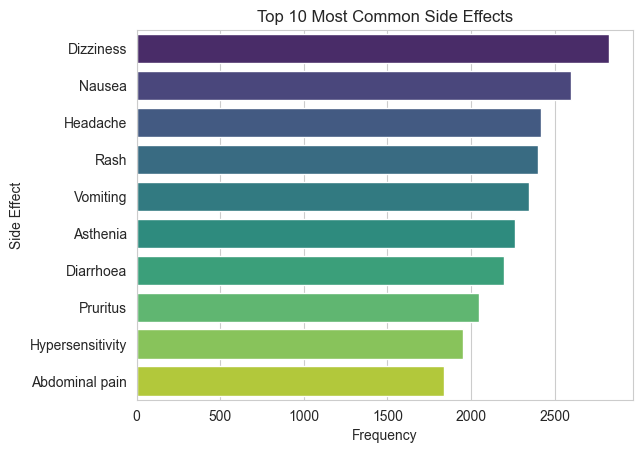

In [62]:
# plot of distribution of side effects
top_se = side_effects['Side_Effect'].value_counts().head(10)
sns.barplot(y=top_se.index, x=top_se.values, palette='viridis')
plt.title('Top 10 Most Common Side Effects')
plt.xlabel('Frequency')
plt.ylabel('Side Effect')
plt.show()

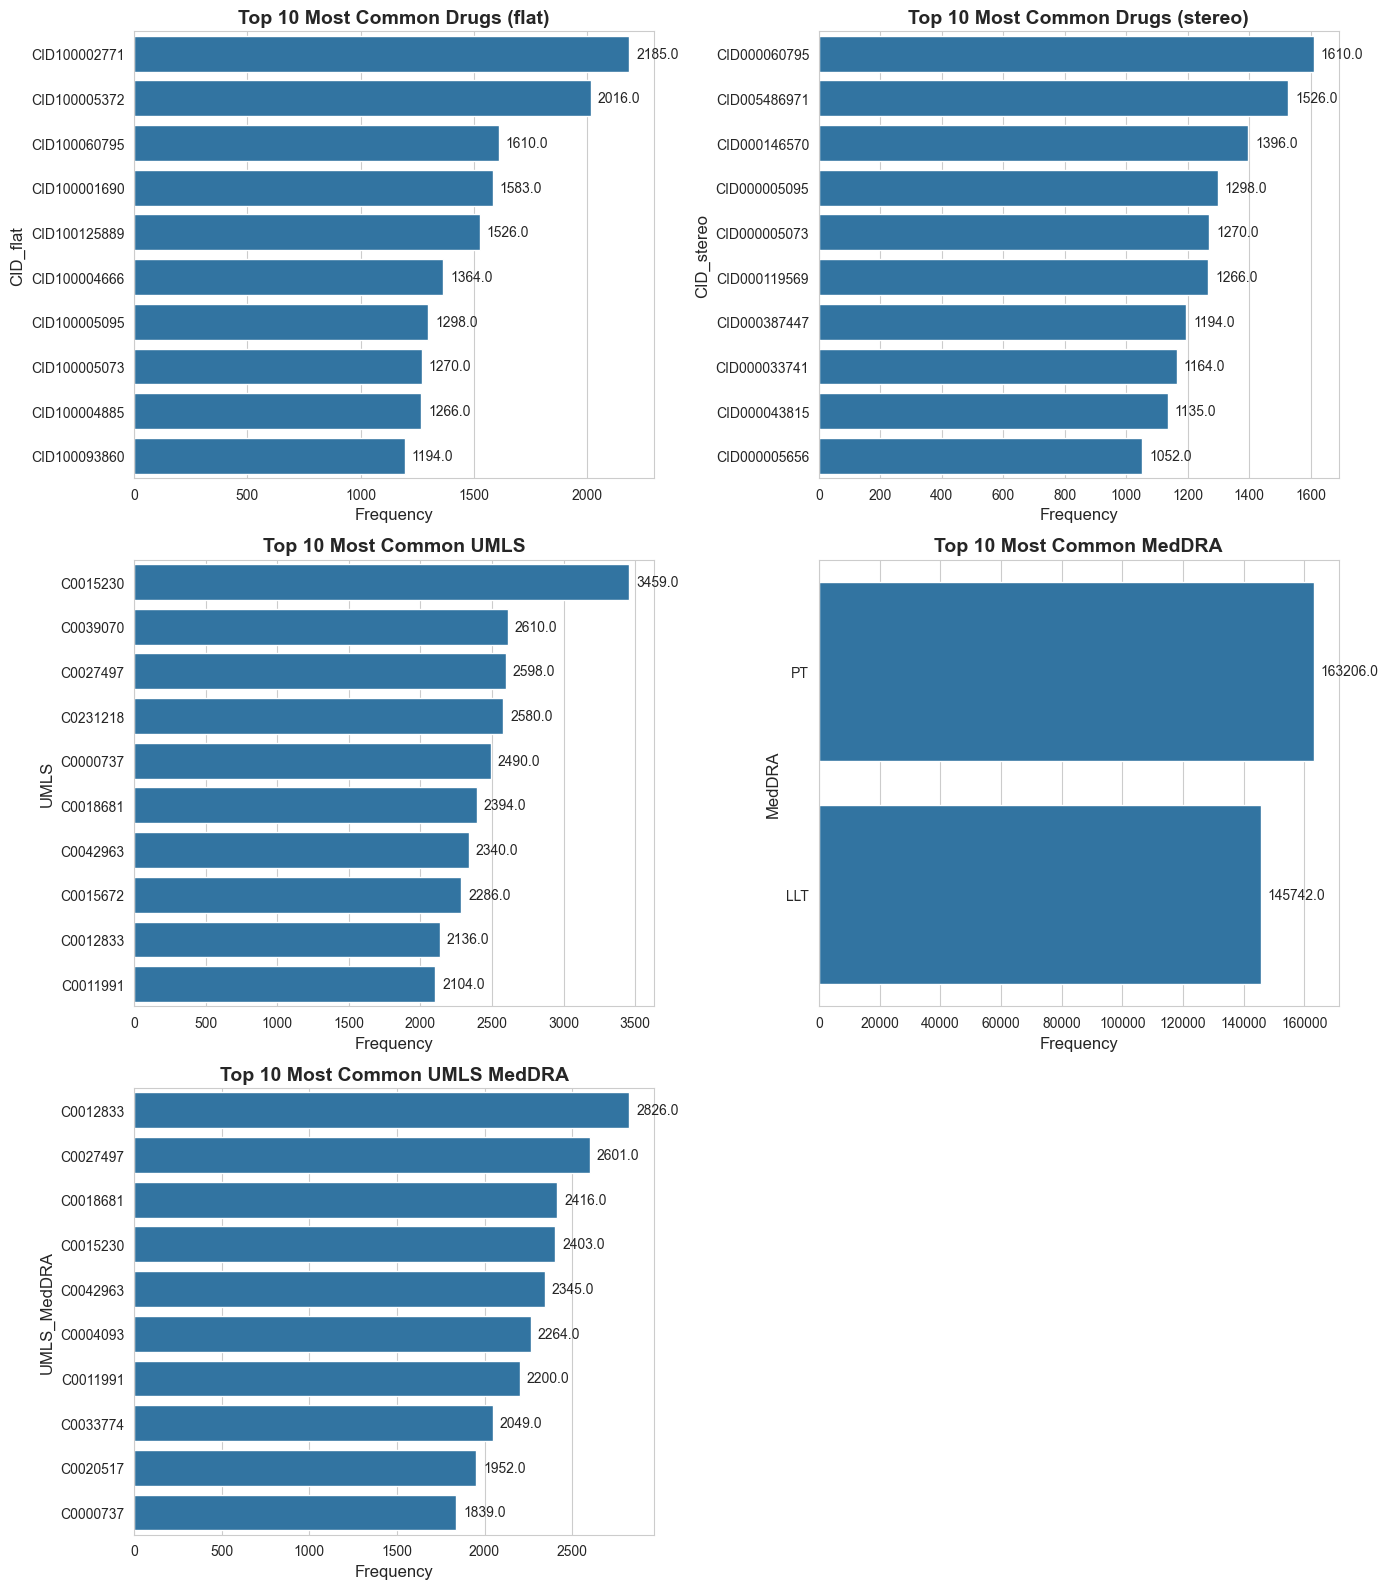

In [63]:
# List of columns and corresponding plot titles
plot_info = {
    'CID_flat': 'Top 10 Most Common Drugs (flat)',
    'CID_stereo': 'Top 10 Most Common Drugs (stereo)',
    'UMLS': 'Top 10 Most Common UMLS',
    'MedDRA': 'Top 10 Most Common MedDRA',
    'UMLS_MedDRA': 'Top 10 Most Common UMLS MedDRA'
}

# Set plot style
sns.set_style('whitegrid')

# Create a figure with subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(14, 16))  
axes = axes.flatten()  # Flatten the 2D array for easy iteration

# Loop through each plot
for i, (col, title) in enumerate(plot_info.items()):
    top_data = side_effects[col].value_counts().head(10)
    
    sns.barplot(y=top_data.index, x=top_data.values, ax=axes[i])
    axes[i].set_title(title, fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Frequency', fontsize=12)
    axes[i].set_ylabel(col, fontsize=12)
    
    # Add value labels to bars
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_width()}', 
                         (p.get_width(), p.get_y() + p.get_height() / 2), 
                         ha='left', va='center', fontsize=10, xytext=(5, 0), textcoords='offset points')

# Remove empty subplot (since we have 5 plots in a 3x2 grid)
fig.delaxes(axes[-1])

# Adjust spacing between plots
plt.tight_layout()
plt.show()


In [76]:
drug_se_counts = side_effects.groupby('CID_flat')['Side_Effect'].nunique().sort_values(ascending=False)
print(drug_se_counts.head(10))

CID_flat
CID100125889    839
CID100060795    827
CID100002771    823
CID100005095    682
CID100005073    666
CID100004885    648
CID100005523    625
CID100004691    624
CID100093860    618
CID100005656    584
Name: Side_Effect, dtype: int64


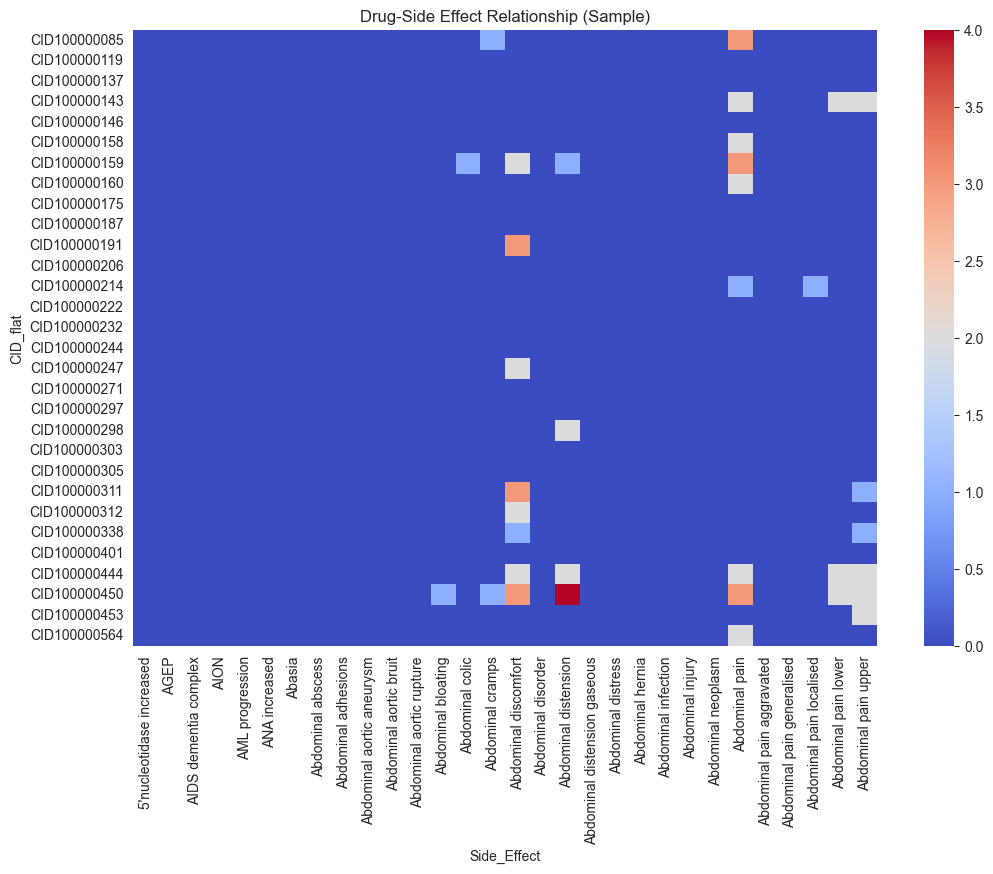

In [78]:
# Create a pivot table (binary matrix: 1 = side effect exists, 0 = no)
pivot_table = side_effects.pivot_table(index='CID_flat', 
                                       columns='Side_Effect', 
                                       aggfunc='size', 
                                       fill_value=0)

# Plotting a heatmap for a sample of the data
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table.iloc[:30, :30], cmap='coolwarm')
plt.title('Drug-Side Effect Relationship (Sample)')
plt.show()
